- Data preprocessing
- Statical analysis
- Sentimental anslysis


- Cross category analysis
- In category analysis

### Data preprocessing

In [2]:
import nltk
from collections import Counter
import pandas as pd
import string
import numpy as np
import sklearn
import scipy.sparse as sp
import math


In [3]:
df = pd.read_pickle("./data/pittsburgh_restaurants.pickle")
df.columns = ['restuaran', 'price', 'sub-category', 'customer', 'date', 'star', 'review']


In [4]:
print df.dtypes
print df.head()

restuaran        object
price             int64
sub-category     object
customer         object
date             object
star            float64
review           object
dtype: object
     restuaran  price sub-category    customer        date  star  \
0  Grandma B’s      1        halal     Mark R.  2016-11-03   5.0   
1  Grandma B’s      1        halal      Dan T.  2016-09-18   4.0   
2  Grandma B’s      1        halal  Maurice J.  2016-06-13   5.0   
3  Grandma B’s      1        halal    Karol R.  2016-07-13   5.0   
4  Grandma B’s      1        halal        T R.  2016-08-28   5.0   

                                              review  
0  Halal hot wings very tasty, well seasoned, fis...  
1  Mom and pop stop - cheap, good and affordable,...  
2  I've frequented this place on several occasion...  
3  Breakfast is cooked to order. The food is deli...  
4  This place is RIDICULOUSLY GOOD. I got eggs, p...  


we seperate the restaurants into sevearl regions including: 
* middle east asia
* east asia
* south asia
* europe
* north american
* south american
* africa

each category contains several sub-categories, which are shown in the category.list file.

In [5]:
def load_category (file_name):
    categories_name = []
    categories = {}
    temp = open(file_name,'r').read().split('\n')
    
    for term in temp:
        if term.startswith("#"):
            categories[term[2:]]=set()
            categories_name.append(term[2:])
            
        else:
            categories[categories_name[len(categories_name)-1]].add(term)
   
    return categories_name, categories

In [6]:
categories_name, categories = load_category("category.list")
for name in categories_name:
    print 'Category: ', name, '\t#sub-categories:',len(categories[name])
    print categories[name]

Category:  middle east asia 	#sub-categories: 9
set(['indpak', 'arabian', 'mideastern', 'halal', 'himalayan', 'afghani', 'pakistani', 'syrian', 'persian'])
Category:  east asia 	#sub-categories: 9
set(['hkcafe', 'chinese', 'panasian', 'taiwanese', 'japanese', 'asianfusion', 'mongolian', 'korean', 'thai'])
Category:  south asia 	#sub-categories: 8
set(['singaporean', 'filipino', 'vietnamese', 'malaysian', 'bangladeshi', 'burmese', 'laotian', 'cambodian'])
Category:  europe 	#sub-categories: 28
set(['portuguese', 'irish', 'czech', 'basque', 'mediterranean', 'moroccan', 'spanish', 'scottish', 'srilankan', 'polish', 'modern_european', 'turkish', 'german', 'belgian', 'austrian', 'hungarian', 'ukrainian', 'french', 'iberian', 'catalan', 'slovakian', 'armenian', 'russian', 'uzbek', 'british', 'scandinavian', 'greek', 'italian'])
Category:  north american 	#sub-categories: 8
set(['cajun', 'tradamerican', 'mexican', 'nicaraguan', 'hawaiian', 'newmexican', 'caribbean', 'newamerican'])
Category: 

We then definea a function to process the text reviews

In [7]:
from nltk.stem import WordNetLemmatizer
def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    text = text.lower()
    text = text.replace("'s","")
    text = text.replace("'","")
    replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(replace_punctuation)
    
    tokens = nltk.word_tokenize(text)
    ans = []
    for token in tokens:
        try:
            lemma = lemmatizer.lemmatize(token)
            ans.append(lemma)
        except:
            pass
    return ans

Then we load the data into a dictionay 'processed_category', **ps. this might takes several minutes**.

In [8]:
processed_category = {}
for name in categories_name:
    cur_df = df.loc[df['sub-category'].isin(categories[name])]
    cur_df.reset_index(drop=True)
    cur_df.loc[:,'review'] = cur_df['review'].apply(lambda x : process(x.encode('utf-8')))
    processed_category[name]=cur_df


/Users/atrdjune/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Then, let us explore the overal statistic of each category:

In [9]:
print '%20s|\t%10s|\t%10s|\t%10s|\t%10s|\t%10s' % ('category','number','star(mean)','star(variance)','price(mean)','price(variance)')
print '------------------------------------------------------------------------------------------------------------------'
for name in processed_category.keys():
    print '%20s|\t%10d|\t%10.4f|\t%10.4f|\t%10.4f|\t%10.4f' % (name, len(processed_category[name]), 
                                    processed_category[name]['star'].mean(),  processed_category[name]['star'].var(),
                                    processed_category[name]['price'].mean(),  processed_category[name]['price'].var()        )


            category|	    number|	star(mean)|	star(variance)|	price(mean)|	price(variance)
------------------------------------------------------------------------------------------------------------------
              europe|	     18370|	    3.8431|	    1.5909|	    1.9820|	    0.3664
           east asia|	     15963|	    3.6981|	    1.6363|	    1.8530|	    0.2736
    middle east asia|	      2802|	    3.8269|	    1.6091|	    1.8837|	    0.1307
              africa|	       111|	    4.0541|	    0.9607|	    1.8108|	    0.2093
      north american|	     35632|	    3.6169|	    1.6458|	    1.8898|	    0.3233
          south asia|	      1528|	    3.8364|	    1.4192|	    1.5988|	    0.2443
      south american|	      2583|	    4.2350|	    1.0458|	    1.9911|	    0.2226


### Cross-category analysis

Firstly, we need to remove the stopwords and count the unigram(single words)

In [10]:
from collections import Counter
from string import punctuation

def word_counter(all_review, n=50):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    with_stp = Counter()
    without_stp  = Counter()
    for review in all_review:
        with_stp.update(w for w in review if w in stopwords)
        without_stp.update(w for w in review if w not in stopwords)
    return [x for x in with_stp.most_common(n)],[y for y in without_stp.most_common(n)]



We then use the wordCloud to visualize the most common words of each category. WordCloud is a convenient opensourse tool, which can download from http://amueller.github.io/word_cloud/

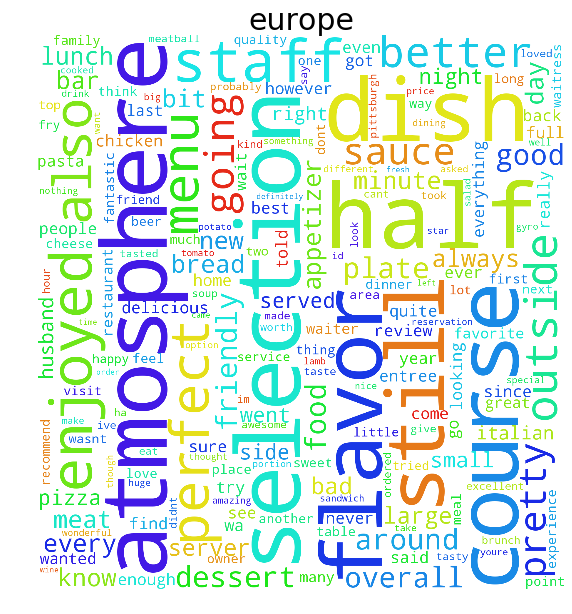

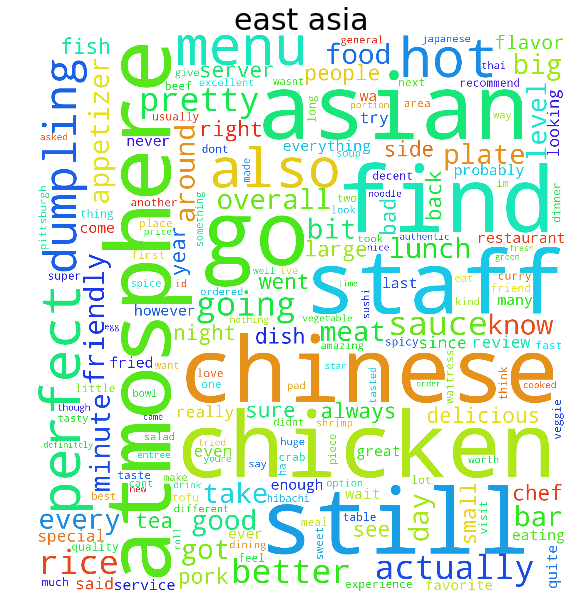

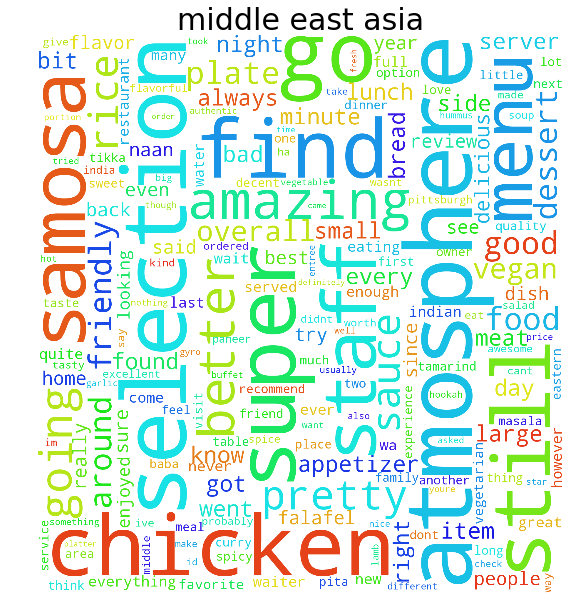

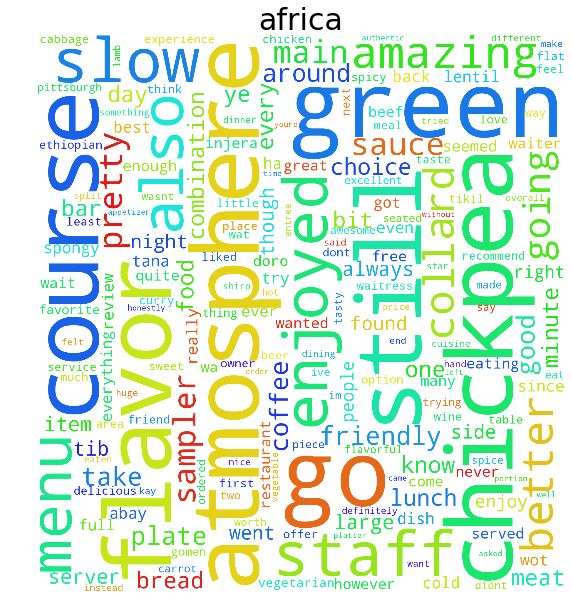

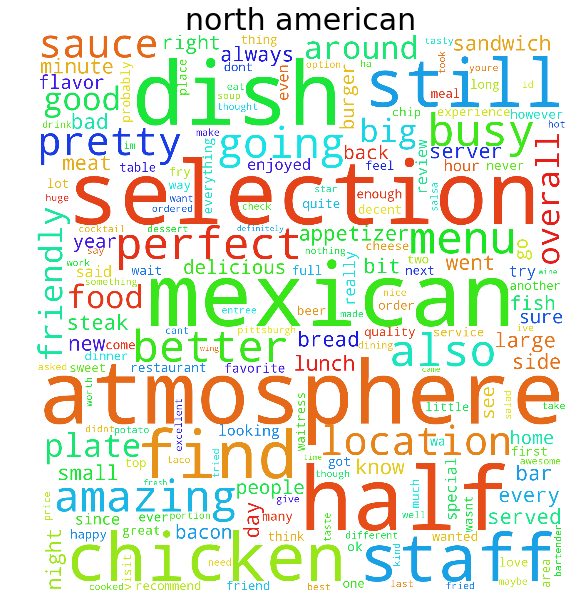

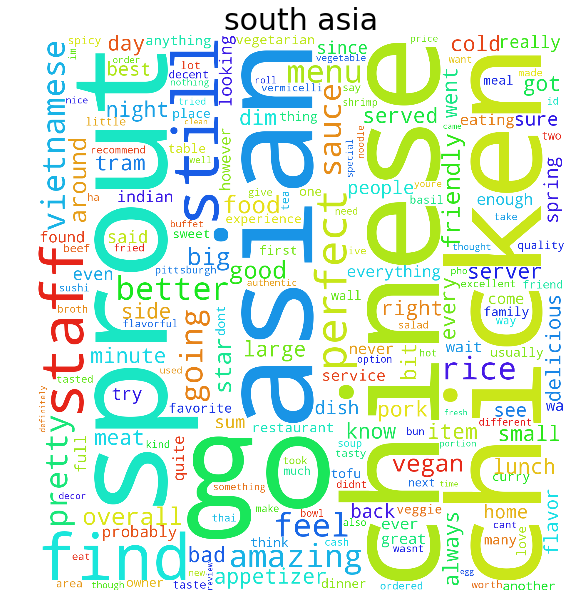

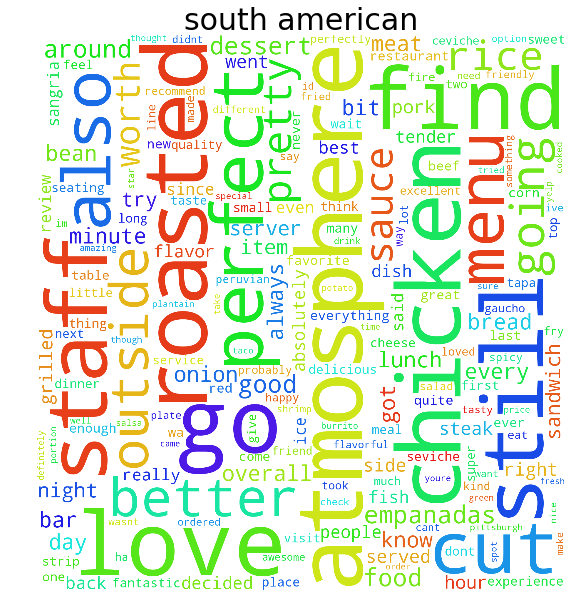

In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordCloud(processed_category):
    i=0
    for name in processed_category.keys():
        with_stp, without_stp = word_counter(processed_category[name]['review'], 200)
        str = ""
        w =  [pair[0] for pair in without_stp]
        str = " ".join(w)
        wordcloud = WordCloud(background_color='white',width=1800,height=1900).generate(str)
        plt.figure(i+1, figsize=(10,10), dpi=100)
        plt.axis('off')
        plt.title (name, size=30)
        plt.imshow(wordcloud, cmap=plt.cm.gray)
        # plt.savefig('./'+name+'.png', dpi=300)
        i +=1

plot_wordCloud(processed_category)

### TFIDF weighting

### 2gram model

### Sentimental analysis